# Document classification notebook

This notebook illustrate the lecture on document classification. See first lecture notebook or moodle for explanations on how to set up the proper environment. We will basically here make use of the same environment however augmented with pytorch.

## Dataset 

We will make use of the SST2 dataset from GLUE, a dataset dedicated to sentiment analysis. The task at hand is the classification of short utterances stating an opinion about a movue as expressing a positive (1) or a negative (0) opinion.

SST2 data was initially downloaded from https://dl.fbaipublicfiles.com/glue/data/SST-2.zip. Unfortunately doesn't have a label on the test data and there are discrepancies between train and dev, the latter having punctuation marks that the former does not have. We'll thus downsize the train set and split it into train, validation and test subsets. 

More info on the data at https://nlp.stanford.edu/sentiment/index.html.

Note that data preparation with SST2 is minimal as utterances are short, already cleaned with no punctuations and weird signs. 

If you want to explore further text classification and data preparation, you can also play with the IMDb dataset that contains movie reviews that are much longer than single utterances. See https://ai.stanford.edu/~amaas/data/sentiment for details. You can get the raw data from there but I'm providing you with an easier json version to load

## Methods

The idea of this notebook is to illustrate a number of methods for text classification. Ideally, we should implement four: 
- an average word2vec approach with a neural network classifier
- an average embedding approach with a neural network classifier
- a recurrent neural network approach

In [1]:
import csv
import json
import numpy as np
from tqdm import tqdm
import statistics
from collections import Counter

# from sklearn.neighbors import NearestNeighbors
# from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

## Loading and tokenizing the dataset

Let's first load the data, clean a bit and tokenize. Last cell provides basic statistics on the corpus.

Punctuation marks were already removed in SST2 and all data is uncased so tokenization remains minimal here. It basically consists in separating tokens based on spaces after getting rid of weird symbols we don't want to bother with.

Note that in real life, if data hasn't been pre-processed as it is now, you'd have to invoke a real tokenizer such as the ones we made us of during the first lecture (e.g., NLTK sent_tokenize and word_tokenize, one of spaCy's pipeline). 

In [2]:
#
# Let's first load raw data from the CSV files. 
#

import csv

def load_tsv_data(fn: str) -> list[dict]:
    '''
    Load data from file
    '''
    
    with open(fn, 'r') as f:
        dat = [x for x in csv.DictReader(f, delimiter="\t")] 

    return dat    
    
data = load_tsv_data('./SST-2/train.tsv')

for i in range(10):
    print('sample {} -- class={}, string=/{}/'.format(i, data[i]['label'], data[i]['sentence']))


sample 0 -- class=0, string=/hide new secretions from the parental units /
sample 1 -- class=0, string=/contains no wit , only labored gags /
sample 2 -- class=1, string=/that loves its characters and communicates something rather beautiful about human nature /
sample 3 -- class=0, string=/remains utterly satisfied to remain the same throughout /
sample 4 -- class=0, string=/on the worst revenge-of-the-nerds clichés the filmmakers could dredge up /
sample 5 -- class=0, string=/that 's far too tragic to merit such superficial treatment /
sample 6 -- class=1, string=/demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . /
sample 7 -- class=1, string=/of saucy /
sample 8 -- class=0, string=/a depressed fifteen-year-old 's suicidal poetry /
sample 9 -- class=1, string=/are more deeply thought through than in most ` right-thinking ' films /


In [3]:
#
# Basic tokenization and cleansing of the utterances to classify. 
# 

def clean_and_tokenize_utterance(x: dict) -> dict:
    '''
    Tokenize utterance with basic rules and convert labels to int. Input an entry of the dataset as
    a dict() and returns the dictionary augmented with the list of tokens (as strings). Also converts
    the label to an integer.
    '''
    unwanted =  ("``", "''", "'", "`", "--", ",", ".")
    
    x['tokens'] = [token for token in x['sentence'].split() if token not in unwanted]
    x['label'] = int(x['label'])
    
    return x

# apply the utterance-level tokenizer to each data item
data = list(map(clean_and_tokenize_utterance, data))

for i in range(10):
    print('sample {} -- class={}, string=/{}/, tokens={}'.format(i, data[i]['label'], data[i]['sentence'], data[i]['tokens']))

# ========================================================
# TODO
# 
# Question: What do you think of the tokenization? Is it good, bad? What could cause problems later on 
# in the process of designing an utterance classifier?
# There are words that are common in the classes of 0 and 1. There are positive words like "merit" that could classify as 0.

sample 0 -- class=0, string=/hide new secretions from the parental units /, tokens=['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units']
sample 1 -- class=0, string=/contains no wit , only labored gags /, tokens=['contains', 'no', 'wit', 'only', 'labored', 'gags']
sample 2 -- class=1, string=/that loves its characters and communicates something rather beautiful about human nature /, tokens=['that', 'loves', 'its', 'characters', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature']
sample 3 -- class=0, string=/remains utterly satisfied to remain the same throughout /, tokens=['remains', 'utterly', 'satisfied', 'to', 'remain', 'the', 'same', 'throughout']
sample 4 -- class=0, string=/on the worst revenge-of-the-nerds clichés the filmmakers could dredge up /, tokens=['on', 'the', 'worst', 'revenge-of-the-nerds', 'clichés', 'the', 'filmmakers', 'could', 'dredge', 'up']
sample 5 -- class=0, string=/that 's far too tragic to merit such superficial

In [4]:
#
# Check some basic statistics on the data
#

nsamples = len(data)
nlabels = 2
nlabels0 = len([x for x in data if x['label'] == 0])
nlabels1 = len([x for x in data if x['label'] == 1])

ntokens = [len(x['tokens']) for x in data]

m = statistics.mean(ntokens)
m2 = statistics.median(ntokens)
sdev = statistics.stdev(ntokens)
    
print('{:35s} {}  {}/{}'.format('Number of samples in dataset', nsamples, nlabels0, nlabels1))
print('{:35s} min={}  max={}  mean={:.1f}  median={}  sdev={:.1f}'.format('Number of tokens per utterance', min(ntokens), max(ntokens), m, m2, sdev))


Number of samples in dataset        67349  29780/37569
Number of tokens per utterance      min=1  max=48  mean=8.7  median=6  sdev=7.4


## Building the vocabulary

As we will design models that define statistics on tokens, we first have to build the vocabulary that we will be able to represent. A common choice when not using subword tokenization is to consider the most frequent tokens as the vocabulary.

We'll limit ourselves to simple terms (as opposed to complex terms such as 'can opener' or 'neural network') and simply select the most frequent terms in the corpus.

Note that many toolkits for NLP provide a sort of equivalent function, e.g., 
- gensim.corpora.dictionary.Dictionary -- https://radimrehurek.com/gensim/corpora/dictionary.html#
- tf.keras.preprocessing.text.Tokenizer -- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- torchtext.vocab -- https://pytorch.org/text/stable/vocab.html

But for pedagogical purposes, we'll do it once all by ourselves ;).


In [ ]:
#
# Check all tokens that appear in the dataset and count the number of times they appear.
#

counter = Counter()
   
for item in data:
    #
    # If we were to implement filters, e.g., on the POS tags, that's the place
    # where it could/should be done. We'd for instance create a temporary list
    # of relevant tokens before updating counter instead of taking all the tokens
    # as is.
    counter.update(item['tokens'])

counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse = True))

#
# Pretty print a number of things
#
print('total number of tokens in dataset =', len(counter))
print('most frequent tokens:')
for x in list(counter.keys())[:20]:
    print(f"   {x:18}  {counter[x]}")
print('\nleast frequent tokens:')
for x in list(counter.keys())[-20:]:
    print(f"   {x:18}  {counter[x]}")

# ========================================================
# TODO
# 
# Comment the most and least frequent tokens and think about how you could get
# a list of tokens of interest other than by selecting the most frequent ones.
# Remove the most frequent tokens that are not useful for classification. Use POS to remove the DETs for example.
# Use the least frequent tokens to remove the words that are not useful for classification.
# Add 1 for the least frequent tokens to avoid the division by zero and smoothing the data.

total number of tokens in dataset = 14809
most frequent tokens:
   the                 27205
   a                   21609
   and                 19920
   of                  17907
   to                  12538
   's                  8764
   is                  8685
   that                7759
   in                  7495
   it                  7078
   as                  5088
   with                4745
   an                  4133
   film                4038
   its                 3924
   for                 3913
   movie               3563
   this                3365
   you                 2749
   but                 2690

least frequent tokens:
   beresford           1
   trey                1
   findings            1
   colonialism         1
   foo                 1
   yung                1
   coburn              1
   veggietales         1
   methodical          1
   jeong-hyang         1
   theorizing          1
   colosseum           1
   o.                  1
   antagonism         

In [6]:
#
# Let's build the vocabulary from there, selecting the most frequent terms. Note that another common
# choice is to keep tokens that appear at least a certain number of times in the dataset.
#
# We will include two special tokens in the vocabulary:
#.  - PAD: the id of the padding token required for sequence models
#   - UNK: the id to assign to tokens that are not in the vocabulary
#
# The vocabulary will be dictionary mapping string to ids.
#

nterms = 4000 # number of terms to keep in the vocabulary

# voc = list(counter.keys())[:nterms]
# for x in voc[-20:]:
#    print(f"   {x:18}  {count[x]}")

vocab = {'PAD': 0, 'UNK': 1} # initialize with the two special tokens before updating with actual regular tokens
offset = len(vocab)
vocab.update({x: i+offset for i,x in enumerate(list(counter.keys())[:nterms])})

print(len(vocab))
print(list(vocab.keys())[:20])

# for pretty printing later on, let's build a reverse mapping id2str from token IDs to the corresponding string
id2str = list(vocab.keys())

4002
['PAD', 'UNK', 'the', 'a', 'and', 'of', 'to', "'s", 'is', 'that', 'in', 'it', 'as', 'with', 'an', 'film', 'its', 'for', 'movie', 'this']


## Encoding and splitting data to create pytorch datasets and dataloaders

Last step before we can start building classifier, we have to split the dataset into train/validation/test and encode input sequences into list of integers rather than list of strings. 

We also have to convert each dataset into a pytorch Dataset that will be batched automatically through the Dataloader. 

### Encoding and splitting

In [7]:
#
# Encoding the data simply means converting tokens from string to integer ids that are more suited for
# modeling and embedding. We will simply add a field 'ids' to each data item holding the list of token ids
#

def encode_utterance(x: dict) -> dict:
    '''
    Encode utterance according to the mapping provided by v. Input an entry of the dataset as
    a dict() and returns the dictionary augmented with the list of tokens (as strings). For 
    practical reasons, we're also adding a ids_no_unk field where unknown token ids are discarded.
    '''
    global vocab
    
    unk_id = vocab['UNK']
    
    x['ids'] = [vocab.get(token, unk_id) for token in x['tokens']] 
    x['ids_no_unk'] = [x for x in x['ids'] if x != unk_id]
    
    return x

data = list(map(encode_utterance, data))

print(data[0])


{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'tokens': ['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units'], 'ids': [1, 87, 1, 34, 2, 1, 1], 'ids_no_unk': [87, 34, 2]}


In [8]:
#
# Let's finally split the data into three datasets
#

fold = dict()

fold['train'], buf = train_test_split(data, test_size=0.3, random_state=42)
fold['valid'], fold['test'] = train_test_split(buf, test_size=0.5, random_state=42)

for s in ('train', 'valid', 'test'):
    buf = fold[s]
    n0 = len([x for x in buf if x['label'] == 0])
    n1 = len([x for x in buf if x['label'] == 1])

    print('{:6s} = {}  {}/{}'.format(s, len(buf), n0, n1))

print(fold['train'][0])

train  = 47144  20963/26181
valid  = 10102  4363/5739
test   = 10103  4454/5649
{'sentence': 'our best actors ', 'label': 1, 'tokens': ['our', 'best', 'actors'], 'ids': [202, 74, 174], 'ids_no_unk': [202, 74, 174]}


In [9]:
#
# Save dataset folds for later reuse
#

with open('./SST-2/sst2-tokenized-folds.json', 'w') as f:
    json.dump(fold, f)
    
#
# reload
#
# with open('data.NOSAVE/sst2-tokenized-folds.json', 'r') as f:
#     fold = json.load(f)
#

### Turn datasets into a pytorch Dataset

Batching requires that all sequences have the same length, at least in a batch. 

In practice, this is ensured with a collator function that 0-pads the sequences on a per batch basis. To make it easier and more explicit, we will force all our sequences in the dataset to have the same length right from the start and don't bother with a collator. But we have to keep in mind this is suboptimal.

In [10]:
import torch

from torch.utils.data import Dataset, DataLoader

In [11]:
#
# Define the dataset class to hold the labels and the (padded) input ids referred to as 'encodings'.
#
# I chose to tokenize, encode and pad outside the dataset but this could all be embedded
# in the class constructor. See, e.g.,
# as in https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=3vWRDemOGxJD
#
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        
        assert(len(encodings) == len(labels))
        
        self.nsamples = len(labels)
        
        # print(f'Initializing dataset with {self.nsamples} entries')
        
        self.encodings = encodings # list[list[int]]: contains the padded list of token ids for each sample
        self.labels = labels # list[int]: contains the label for each sample
        self.nlabels = len(set(labels)) # int: number of labels in the dataset

    def __getitem__(self, idx):
        '''
        Returns a dictionary containing the label and padded token ids for a sample
        '''
        
        # print(f'accessing dataset item at index {idx}')
        # print(torch.tensor(self.encodings[idx]), torch.tensor(self.labels[idx]))

        return {'ids': torch.tensor(self.encodings[idx]), 'label': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

#
# Define basic padding function
#
def pad_utterances(x: list, maxlen: int, pad_id: int = 0) -> list:
    '''
    Pad all input utterances up to maxlen, truncating if need be.
    
    Returns a list of padded ids. 
    '''
    
    return [(ids + [pad_id] * (maxlen - len(ids)))[:maxlen] for ids in x]


#
# Function to convert the dataset as a list[dict] into a proper torch.Dataset object
# 
def to_dataset(_data: list[dict], key: str = 'ids', maxlen: int = -1, pad_id: int = 0) -> MyDataset:
    '''
    Convert data as processed before into a proper pyTorch dataset with the specified tokenizer. 
    If maxlen <= 0, then we take the maximum length within the sequence.
    '''

    if maxlen <= 0:
        maxlen = max([len(x[key]) for x in _data])
        print('maxlen set to', maxlen)
        
    ids = [x[key] for x in _data]
    labels = [x['label'] for x in _data]
    encodings = pad_utterances(ids, maxlen)
    
    return MyDataset(encodings, labels)


In [12]:
ds = dict()

ds['train'] = to_dataset(fold['train'], key='ids_no_unk', maxlen=10)
ds['valid'] = to_dataset(fold['valid'], key='ids_no_unk', maxlen=10)
ds['test'] = to_dataset(fold['test'], key='ids_no_unk', maxlen=10)

print('Training set:  nsamples =', ds['train'].nsamples, ' nlabels =', ds['train'].nlabels)

for i in range(3):
    print(fold['train'][i])
    print('   >>', ds['train'][i])


Training set:  nsamples = 47144  nlabels = 2
{'sentence': 'our best actors ', 'label': 1, 'tokens': ['our', 'best', 'actors'], 'ids': [202, 74, 174], 'ids_no_unk': [202, 74, 174]}
   >> {'ids': tensor([202,  74, 174,   0,   0,   0,   0,   0,   0,   0]), 'label': tensor(1)}
{'sentence': 'writing , skewed characters , and the title performance by kieran culkin ', 'label': 0, 'tokens': ['writing', 'skewed', 'characters', 'and', 'the', 'title', 'performance', 'by', 'kieran', 'culkin'], 'ids': [505, 1, 51, 4, 2, 395, 140, 25, 1, 1], 'ids_no_unk': [505, 51, 4, 2, 395, 140, 25]}
   >> {'ids': tensor([505,  51,   4,   2, 395, 140,  25,   0,   0,   0]), 'label': tensor(0)}
{'sentence': 'a delicate ambiguity ', 'label': 1, 'tokens': ['a', 'delicate', 'ambiguity'], 'ids': [3, 776, 1], 'ids_no_unk': [3, 776]}
   >> {'ids': tensor([  3, 776,   0,   0,   0,   0,   0,   0,   0,   0]), 'label': tensor(1)}


## A basic (toy) text classification neural network

Let's start text classification machinery with the basic model that we saw in the lecture that embeds the tokens, takes the average embedding and run a basic feed-forward classifier on top of it.

This section covers several steps in (pytorch) model design
1. define the model, i.e., its architecture
2. organize the dataset into batches, achieved with a Dataloader object in pytorch
3. define the training setup, i.e., optimizer and loss function along with a few parameters (e.g., number of epochs, learning rate)
4. run the training loop
5. evaluate results on the test set

In pytorch, the training loop has to be written explicitly (contrary to the fit() method in scikit-learn or tensorflow). Do does the evaluation loop (contrary to evaluate()). To facilitate things, two generic functions are given, namely train_step() and eval_step(): see below for more comments. These two functions are defined here since it's the first model we are conceiving but they will be used as is for the subsequent models.

### Creating the model and batches

Let's first create the model, batch the data via a DataLoader (this is where we're happy that all encoded sequences are of the same length) and illustrate how we can pass on data for inference.

In [13]:
#
# Define the model as a torch.nn.Module
#

class AvgEmbeddingNN(torch.nn.Module):

    def __init__(self, vocsize, nclasses = 2, embed_dim = 200, dropout = None):
        super(AvgEmbeddingNN, self).__init__()

        self.nclasses = nclasses
        self.vocabulary_size = vocsize
        self.embed_dim = embed_dim
        
        self.embedding = torch.nn.Embedding(vocsize, embed_dim, padding_idx = 0)
        self.dropout = torch.nn.Dropout(dropout) if dropout != None else None
        self.linear = torch.nn.Linear(embed_dim, nclasses)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, **kwargs):
        x = self.embedding(kwargs['ids']) # embed input ids -- batch_size * maxlen * embed_dim
        if self.dropout != None: # dropout embeddings
            x = self.dropout(x)        
        x = torch.mean(x, dim=1) # average embeddings yielding an average tensor -- batch_size * embed_dim
        x = self.softmax(self.linear(x)) # project into posterior probabilities -- batch_size * nclasses

        return x
        
model1 = AvgEmbeddingNN(len(vocab), nclasses = ds['train'].nlabels, embed_dim = 200)


In [14]:
#
# Create batched dataset with data loaders
#

batch_size = 32

loader = dict()
loader['train'] = DataLoader(ds['train'], batch_size=batch_size, shuffle=True) # set to False for debugging purposes
loader['valid'] = DataLoader(ds['valid'], batch_size=batch_size)
loader['test'] = DataLoader(ds['test'], batch_size=batch_size)

print('Number of samples:', len(ds['train']))
print(f'Number of training batches:', len(loader['train']))

Number of samples: 47144
Number of training batches: 1474


In [15]:
# this cell is for illustration purposes only, showing how batches cab be passed and processed to
# the model's forward method at iunference time.

batch = next(iter(loader['train']))
print(batch['ids'].shape)
print(batch)

# Option 1: passing the ids tensor directly as a named argument
output = model1(ids=batch['ids'])
print(output.shape)
print(output)

# Option 2: passing an arbitrary number of named arguments, of which only ids=ids will be used
output = model1(**batch)

torch.Size([32, 10])
{'ids': tensor([[ 409,  269,   34,   27,    0,    0,    0,    0,    0,    0],
        [  14,  508,    6,   91,   90,  484,  166,  295, 2618,   11],
        [   2,  597,    8,  115,    3, 1021,   27,    0,    0,    0],
        [3450,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  22, 3070,    0,    0,    0,    0,    0,    0,    0,    0],
        [  61,    3,   98,   72,    6, 2474,    5,   64,  448,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   2,  148,   25,  633,  558, 1642,    8,   10,    2, 1337],
        [   7,    3, 1922, 2090,    4,    3,  544,    6,    2,  772],
        [  12,   14, 3613,   38,   14,    0,    0,    0,    0,    0],
        [   3,  411,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 654, 1065,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 242,  992,    9,    2, 3741,  807,    8, 3227,   25, 2766],
        [  17, 2821,    0,    0,    0,    0,    0,    0,    0

### Training the model

In pytorch, we have to explicitly write the training iterations. The code will vary little from one model to the other but still, we have to write the training loop explicitly. To simplify things, you are provided with two key functions defined in the following cells. The actual training and evaluation of the model follows.

#### Defining the basic building blocks of the training loop

Two key functions are provided here:

- train_step(): run one epoch given a model, a data loader, a loss function and an optimizer function; the function that should work for all models we'll be playing with

- eval_step(): evaluate the model's accuracy given a model, a data loader

We finally instantiate in the last cell of this section the various functions that we'll be needing for the training such as the optimizer, the loss function, etc.

In [16]:
def train_step(_model, _loader, _loss, _optim, device="cpu", report=0):
    '''
    Generic training step.

    Assumes loader returns batches where the labels are accessed with the 'label' keyword.
    All other keywords are passed as **kwargs to the model.
    
    If report is set to a number, reports stats on training every 'report' batches.

    :return: total_loss accumulated throughout the epoch
    '''

    _model.train(True)
    total_loss = 0.
    running_loss = 0.

    for i, batch in enumerate(_loader):
        _optim.zero_grad()

        labels = batch['label'].to(device)

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        outputs = _model(**inputs)

        loss = _loss(outputs, labels)
        total_loss += loss.item()
        running_loss += loss.item()

        loss.backward()
        _optim.step()

        if report != 0 and i % report == report - 1:
            print('  batch {} avg. loss per batch={:.4f}'.format(i + 1, running_loss / report))
            running_loss = 0.

    _model.train(False)

    return total_loss

In [17]:
def eval_step(_model, _loader, device='cpu', loss_fn=None):
    '''
    Evaluate the model's performance on data within loader.
    
    :return: 
    total_loss accumulated throughout the batches
    accuracy
    '''
    
    # logger.debug('running eval_acc_recprec() on %s', device)

    _model.eval()  # disable training mode

    posteriors = torch.empty((0, _model.nclasses)).to(device)
    labels = torch.empty((0)).to(device)

    total_loss = 0.

    for batch in _loader:
        batch_labels = batch['label'].to(device)
        labels = torch.cat((labels, batch_labels), dim=0)

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}

        with torch.no_grad():
            outputs = _model(**inputs)

        posteriors = torch.cat((posteriors, outputs), dim=0)

        if loss_fn != None:
            loss = loss_fn(outputs, batch_labels)
            total_loss += loss.item()


    labels = labels.cpu()
    posteriors = posteriors.cpu()
    predictions = torch.argmax(posteriors, dim=-1)
    
    return total_loss, accuracy_score(labels, predictions)


In [51]:
#
# Last but not least, we have to set the training parameters and instatiate all the objects 
# needed for training.
#

lr = 1e-4
nepochs = 10
report_freq = 200

# check what device we can work on
if torch.backends.mps.is_built(): # MPS GPU library for MacOS -- requires metal to be installed
    device = "mps"
    torch.mps.empty_cache()
elif torch.cuda.is_available(): # CUDA GPU acceleration available
    device = torch.device('cuda')
else:
    device = "cpu"
print(f'Running on {device} device')

optimizer = torch.optim.AdamW(model1.parameters(), lr=lr)
celoss = torch.nn.CrossEntropyLoss()

Running on cuda device


In [52]:
#
# At last, here we go with the main training loop, iterating over epochs
#

model1.to(device)

for epoch in range(nepochs):
    print(f'epoch: {epoch}')
    
    total_loss = train_step(model1, loader['train'], celoss, optimizer, device=device, report=report_freq)
    _, trn_acc = eval_step(model1, loader['train'], device=device, loss_fn=None)
    
    val_loss, val_acc = eval_step(model1, loader['valid'], device=device, loss_fn=celoss)

    print('  **train** avg_loss={:.4f}    acuracy={:.2f}%'.format(total_loss / len(loader['train']), 100 * trn_acc))
    print('  **valid** avg_loss={:.4f}    acuracy={:.2f}%'.format(val_loss / len(loader['valid']), 100 * val_acc))


epoch: 0
  batch 200 avg. loss per batch=0.5062
  batch 400 avg. loss per batch=0.5021
  batch 600 avg. loss per batch=0.4992
  batch 800 avg. loss per batch=0.5015
  batch 1000 avg. loss per batch=0.4984
  batch 1200 avg. loss per batch=0.4992
  batch 1400 avg. loss per batch=0.4994
  **train** avg_loss=0.5010    acuracy=82.46%
  **valid** avg_loss=0.5122    acuracy=80.07%
epoch: 1
  batch 200 avg. loss per batch=0.4920
  batch 400 avg. loss per batch=0.4998
  batch 600 avg. loss per batch=0.5000
  batch 800 avg. loss per batch=0.4926
  batch 1000 avg. loss per batch=0.4945
  batch 1200 avg. loss per batch=0.4875
  batch 1400 avg. loss per batch=0.4919
  **train** avg_loss=0.4939    acuracy=82.94%
  **valid** avg_loss=0.5065    acuracy=80.52%


In [26]:
_, tst_acc = eval_step(model1, loader['test'], device=device, loss_fn=None)

print('  **test** acuracy={:.2f}%'.format(100 * tst_acc))

  **test** acuracy=79.55%


In [ ]:
### TODO
#
# Visualize the word embeddings learned by the neural network with tSNE. Do we observe the 
# distributional semantic properties?
#
# Revisit the code above to work on lemmas rather than tokens, possibly limiting yourself to noun,
# verbs and adjectives which are the most relevant POS tags for polarity detection (adjectives alone 
# are already pretty good)
#

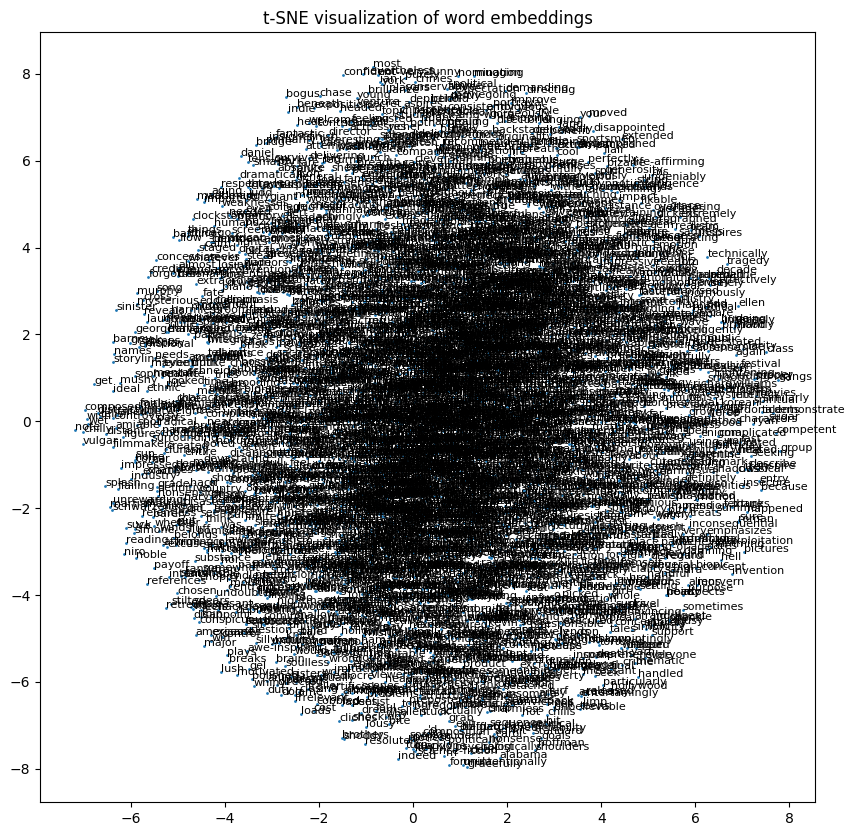

In [21]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Extract the embeddings from the model
embeddings = model1.embedding.weight.detach().cpu().numpy()

# Use TSNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)

# Annotate the plot with the words
for i, word in enumerate(id2str):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.title('t-SNE visualization of word embeddings')
plt.show()

## A recurrent neural network for text classification

Let's illustrate here a different approach based on recurrent neural nets to model the input sequence. The model embeds the token ids, run a recurrent LSTM function to yield the last hidden state as given by the LSTM recursion, passing this last LSTM state into a feed-forward classifier. The only difference from the previous model is in the way we convert the sequence to a fixed length descriptor for the feed-forward classification layer. 

We basically go throught the same steps as for the previous model except that some steps can be factorized between the two models. In particular, data preparation and batching remains the same unless (note that in the previous example, we worked in 'ids_no_unk' tokens -- might be worth to check whether unknown tokens should be kept or not).

For details on the implementation of LSTM cells, see 

- https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html


In [22]:
#
# This is a toy cell to explain how the LSTM cell works and we get out of it.
#

batch = next(iter(loader['train']))
print(batch['ids'].shape)
print(batch)

embedder = torch.nn.Embedding(len(vocab), 5, padding_idx = 0)
lstm = torch.nn.LSTM(5, 5, batch_first=True)  # First 5 is input embedding dimension, second 5 is hidden state dimension

# hidden0 = (torch.zeros(1, 32, 5), torch.zeros(1, 32, 5))
# print(hidden0)

embeddings = embedder(batch['ids'])
print(embeddings.shape)

outputs, (hs, cs) = lstm(embeddings) # lstm(embeddings, hidden0)
print('outputs shape', outputs.shape)
print('hidden shape', hs.shape) # hs is D * num_layers x batch_size x embed_dim

print(hs[0][0]) # first sample last hidden state
print(outputs[0][-1])

torch.Size([32, 10])
{'ids': tensor([[  41,    5,    2,   80,    0,    0,    0,    0,    0,    0],
        [   4, 1046,   20,   10,  608,   34,    0,    0,    0,    0],
        [ 518,  744,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 890,  175,    0,    0,    0,    0,    0,    0,    0,    0],
        [2698,    4, 3669, 3730,  312,    0,    0,    0,    0,    0],
        [  91,   70,    6,   19,  407,    7, 3734, 2647,    0,    0],
        [ 101,  616,   15,    4,    3,  784,    6,    3,  433,  315],
        [1434,   53,  431,  555,   89,  388,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 195,  226,    8,  800, 3799,   25,    3,    5, 2165,   21],
        [ 712,    2,   18,  162,    0,    0,    0,    0,    0,    0],
        [3020,   39,    2,  252, 2206,    5,   16,  887,    0,    0],
        [   2,   18,    7,  861,  301,    9,  372,  134,   22

In [23]:
#
# Define the model as a torch.nn.Module
#

class LSTMNN(torch.nn.Module):

    def __init__(self, vocsize, nclasses = 2, embed_dim = 200, dropout = None):
        super(LSTMNN, self).__init__()

        self.nclasses = nclasses
        self.vocabulary_size = vocsize
        self.embed_dim = embed_dim
        
        self.embedding = torch.nn.Embedding(vocsize, embed_dim, padding_idx = 0)
        if dropout != None:
            self.dropout = torch.nn.Dropout(dropout)
            self.rnn = torch.nn.LSTM(embed_dim, embed_dim, dropout = dropout, batch_first=True)
        else:
            self.dropout = None
            self.rnn = torch.nn.LSTM(embed_dim, embed_dim, batch_first=True) 
        self.linear = torch.nn.Linear(embed_dim, nclasses)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, **kwargs):
        x = self.embedding(kwargs['ids']) # embed input ids -- batch_size * maxlen * embed_dim
        if self.dropout != None: # dropout embeddings
            x = self.dropout(x)        
        _, (x, _) =  self.rnn(x) # run through recurrent cells -- batch_size * embed_dim
        x = self.softmax(self.linear(x[0])) # project into posterior probabilities -- batch_size * nclasses

        return x
        
model2 = LSTMNN(len(vocab), nclasses = ds['train'].nlabels, embed_dim = 200)


In [24]:
#
# Redefining here the training parameters and objects needed for training for practical reasons. They are 
# the same as for the previous model except for the optimizer but is't more convenient to have them here 
# if we want to tweak things a bit.
#

lr = 1e-4
nepochs = 10
report_freq = 200

# check what device we can work on
if torch.backends.mps.is_built(): # MPS GPU library for MacOS -- requires metal to be installed
    device = "mps"
    torch.mps.empty_cache()
elif torch.cuda.is_available(): # CUDA GPU acceleration available
    device = torch.device('cuda')
else:
    device = "cpu"
print(f'Running on {device} device')

optimizer = torch.optim.AdamW(model2.parameters(), lr=lr)
celoss = torch.nn.CrossEntropyLoss()

Running on cuda device


In [27]:
#
# Training loop, using the two generic functions we built before
#

model2.to(device)

for epoch in range(nepochs):
    print(f'epoch: {epoch}')
    
    total_loss = train_step(model2, loader['train'], celoss, optimizer, device=device, report=report_freq)
    _, trn_acc = eval_step(model2, loader['train'], device=device, loss_fn=None)
    
    val_loss, val_acc = eval_step(model2, loader['valid'], device=device, loss_fn=celoss)

    print('  **train** avg_loss={:.4f}    acuracy={:.2f}%'.format(total_loss / len(loader['train']), 100 * trn_acc))
    print('  **valid** avg_loss={:.4f}    acuracy={:.2f}%'.format(val_loss / len(loader['valid']), 100 * val_acc))


epoch: 0
  batch 200 avg. loss per batch=0.6855
  batch 400 avg. loss per batch=0.6777
  batch 600 avg. loss per batch=0.6417
  batch 800 avg. loss per batch=0.6068
  batch 1000 avg. loss per batch=0.5941
  batch 1200 avg. loss per batch=0.5767
  batch 1400 avg. loss per batch=0.5698
  **train** avg_loss=0.6189    acuracy=76.30%
  **valid** avg_loss=0.5602    acuracy=73.67%
epoch: 1
  batch 200 avg. loss per batch=0.5403
  batch 400 avg. loss per batch=0.5383
  batch 600 avg. loss per batch=0.5284
  batch 800 avg. loss per batch=0.5189
  batch 1000 avg. loss per batch=0.5143
  batch 1200 avg. loss per batch=0.5046
  batch 1400 avg. loss per batch=0.5088
  **train** avg_loss=0.5212    acuracy=82.05%
  **valid** avg_loss=0.5182    acuracy=78.23%
epoch: 2
  batch 200 avg. loss per batch=0.4885
  batch 400 avg. loss per batch=0.4857
  batch 600 avg. loss per batch=0.4845
  batch 800 avg. loss per batch=0.4816
  batch 1000 avg. loss per batch=0.4711
  batch 1200 avg. loss per batch=0.4751
 

In [28]:
_, tst_acc = eval_step(model2, loader['test'], device=device, loss_fn=None)

print('  **test** acuracy={:.2f}%'.format(100 * tst_acc))

  **test** acuracy=84.31%


## Going further with the notebook

These two examples are pretty straightforward models operating on fairly basic representations of the data. They are mostly intended to illustrate data preparation, model design and pytorch implementation of NLP models and recurrent neural nets. 

Now that you are kind of acquainted with these mechanisms, you can adapt these scripts to make things better. In particular, the following points deserve attention and I strongly invite you to consider their implementation to fully get familiar with an NLP pipeline for document classification.

1. The choice of vocabulary is rather poor here and deserves significant improvement. For polarity detection, there's no need to work with "words" and lemmas are sufficient. Also for the approach based on average embeddings, function words (determiners, auxiliary, etc,) are not necessary and can be safely removed. You should adapt this first method so that the vocabulary is built from lemmatized input keeping only nouns, verbs and adjectives in the vocabulary. To do so, you need to run POS tagging and lemmatization (see first notebook on how to do that with NLTK for instance), adapt the vocabulary and hence the subsequent steps (preparation and encoding of the data).

2. With a better choice of vocabulary, there should be much less UNK tokens, which should help the RNN approach. You are thus invited to test and compare the average word embedding and RNN approaches taking into account the UNK tokens which were discarded in the initial implementation (using ids_no_unk as key when converting the data into a pytorch Dataset). When doing so, you might want to think about whether lemmatization and/or POS tag filtering should be taken into account or not.

Also, if you might want to compare with basic statistical methods based on symbolic word representations rather than embedding, for instance implementing a vector space model with tf-idf weights along with a k-nn classifier or using a polarity semantic network like sentiwordnet.

There are many other things to do and we will revisit this task later with large language models.

In [29]:
data = load_tsv_data('./SST-2/train.tsv')

for i in range(10):
    print('sample {} -- class={}, string=/{}/'.format(i, data[i]['label'], data[i]['sentence']))

sample 0 -- class=0, string=/hide new secretions from the parental units /
sample 1 -- class=0, string=/contains no wit , only labored gags /
sample 2 -- class=1, string=/that loves its characters and communicates something rather beautiful about human nature /
sample 3 -- class=0, string=/remains utterly satisfied to remain the same throughout /
sample 4 -- class=0, string=/on the worst revenge-of-the-nerds clichés the filmmakers could dredge up /
sample 5 -- class=0, string=/that 's far too tragic to merit such superficial treatment /
sample 6 -- class=1, string=/demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . /
sample 7 -- class=1, string=/of saucy /
sample 8 -- class=0, string=/a depressed fifteen-year-old 's suicidal poetry /
sample 9 -- class=1, string=/are more deeply thought through than in most ` right-thinking ' films /


In [30]:
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

In [31]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to lemmatize tokens in a sentence
def lemmatize_sentence(sentence):
    # Tokenize the sentence
    tokens = sentence.split()
    # Get POS tags for the tokens
    pos_tags = pos_tag(tokens)
    # Lemmatize each token based on its POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]
    return lemmatized_tokens

# Apply lemmatization to the dataset
for item in data:
    item['lemmatized_tokens'] = lemmatize_sentence(item['sentence'])

# Print the first 10 samples to verify
for i in range(10):
    print('sample {} -- class={}, string=/{}/, lemmatized_tokens={}'.format(i, data[i]['label'], data[i]['sentence'], data[i]['lemmatized_tokens']))

sample 0 -- class=0, string=/hide new secretions from the parental units /, lemmatized_tokens=['hide', 'new', 'secretion', 'from', 'the', 'parental', 'unit']
sample 1 -- class=0, string=/contains no wit , only labored gags /, lemmatized_tokens=['contain', 'no', 'wit', ',', 'only', 'labor', 'gag']
sample 2 -- class=1, string=/that loves its characters and communicates something rather beautiful about human nature /, lemmatized_tokens=['that', 'love', 'it', 'character', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature']
sample 3 -- class=0, string=/remains utterly satisfied to remain the same throughout /, lemmatized_tokens=['remains', 'utterly', 'satisfy', 'to', 'remain', 'the', 'same', 'throughout']
sample 4 -- class=0, string=/on the worst revenge-of-the-nerds clichés the filmmakers could dredge up /, lemmatized_tokens=['on', 'the', 'bad', 'revenge-of-the-nerds', 'clichés', 'the', 'filmmaker', 'could', 'dredge', 'up']
sample 5 -- class=0, string=/th

In [33]:
# Function to filter tokens based on POS tags
def filter_tokens(tokens, pos_tags):
    filtered_tokens = [token for token, pos in zip(tokens, pos_tags) if pos[1].startswith('N') or pos[1].startswith('V') or pos[1].startswith('J')]
    return filtered_tokens

# Apply filtering to the dataset
for item in data:
    pos_tags = pos_tag(item['lemmatized_tokens'])
    item['filtered_tokens'] = filter_tokens(item['lemmatized_tokens'], pos_tags)

# Print the first 10 samples to verify
for i in range(10):
    print('sample {} -- class={}, string=/{}/, filtered_tokens={}'.format(i, data[i]['label'], data[i]['sentence'], data[i]['filtered_tokens']))

sample 0 -- class=0, string=/hide new secretions from the parental units /, filtered_tokens=['new', 'secretion', 'parental', 'unit']
sample 1 -- class=0, string=/contains no wit , only labored gags /, filtered_tokens=['contain', 'wit', 'labor', 'gag']
sample 2 -- class=1, string=/that loves its characters and communicates something rather beautiful about human nature /, filtered_tokens=['love', 'character', 'communicates', 'something', 'beautiful', 'human', 'nature']
sample 3 -- class=0, string=/remains utterly satisfied to remain the same throughout /, filtered_tokens=['remains', 'utterly', 'satisfy', 'remain', 'same']
sample 4 -- class=0, string=/on the worst revenge-of-the-nerds clichés the filmmakers could dredge up /, filtered_tokens=['bad', 'revenge-of-the-nerds', 'clichés', 'filmmaker', 'dredge']
sample 5 -- class=0, string=/that 's far too tragic to merit such superficial treatment /, filtered_tokens=["'s", 'tragic', 'merit', 'such', 'superficial', 'treatment']
sample 6 -- clas

In [36]:
# Check all tokens that appear in the dataset and count the number of times they appear.
#

counter = Counter()
   
for item in data:
    #
    # If we were to implement filters, e.g., on the POS tags, that's the place
    # where it could/should be done. We'd for instance create a temporary list
    # of relevant tokens before updating counter instead of taking all the tokens
    # as is.
    counter.update(item['filtered_tokens'])

counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse = True))

#
# Pretty print a number of things
#
print('total number of filtered_tokens in dataset =', len(counter))
print('most frequent filtered_tokens:')
for x in list(counter.keys())[:20]:
    print(f"   {x:18}  {counter[x]}")
print('\nleast frequent tokens:')
for x in list(counter.keys())[-20:]:
    print(f"   {x:18}  {counter[x]}")

total number of filtered_tokens in dataset = 12140
most frequent filtered_tokens:
   be                  15426
   film                4649
   movie               4245
   have                4051
   's                  3051
   make                2325
   do                  2179
   good                1704
   character           1628
   story               1557
   bad                 1282
   funny               1239
   time                1203
   work                1200
   comedy              1186
   i                   1101
   performance         1036
   see                 1025
   way                 998
   go                  900

least frequent tokens:
   yung                1
   coburn              1
   invokes             1
   mislead             1
   ensures             1
   veggietales         1
   methodical          1
   jeong-hyang         1
   somewhat            1
   theorizing          1
   colosseum           1
   distinguishes       1
   everett             1
   antagon

sample 0 -- label=0
sample 1 -- label=0
sample 2 -- label=1
sample 3 -- label=0
sample 4 -- label=0
sample 5 -- label=0
sample 6 -- label=1
sample 7 -- label=1
sample 8 -- label=0
sample 9 -- label=1


In [37]:
#
# Let's build the vocabulary from there, selecting the most frequent terms. Note that another common
# choice is to keep tokens that appear at least a certain number of times in the dataset.
#
# We will include two special tokens in the vocabulary:
#.  - PAD: the id of the padding token required for sequence models
#   - UNK: the id to assign to tokens that are not in the vocabulary
#
# The vocabulary will be dictionary mapping string to ids.
#

nterms = 4000 # number of terms to keep in the vocabulary

# voc = list(counter.keys())[:nterms]
# for x in voc[-20:]:
#    print(f"   {x:18}  {count[x]}")

vocab = {'PAD': 0, 'UNK': 1} # initialize with the two special tokens before updating with actual regular tokens
offset = len(vocab)
vocab.update({x: i+offset for i,x in enumerate(list(counter.keys())[:nterms])})

print(len(vocab))
print(list(vocab.keys())[:20])

# for pretty printing later on, let's build a reverse mapping id2str from token IDs to the corresponding string
id2str = list(vocab.keys())

4002
['PAD', 'UNK', 'be', 'film', 'movie', 'have', "'s", 'make', 'do', 'good', 'character', 'story', 'bad', 'funny', 'time', 'work', 'comedy', 'i', 'performance', 'see']


In [42]:
#
# Encoding the data simply means converting tokens from string to integer ids that are more suited for
# modeling and embedding. We will simply add a field 'ids' to each data item holding the list of token ids
#

def encode_utterance(x: dict) -> dict:
    '''
    Encode utterance according to the mapping provided by v. Input an entry of the dataset as
    a dict() and returns the dictionary augmented with the list of tokens (as strings). For 
    practical reasons, we're also adding a ids_no_unk field where unknown token ids are discarded.
    '''
    global vocab
    
    unk_id = vocab['UNK']
    
    x['ids'] = [vocab.get(token, unk_id) for token in x['filtered_tokens']] 
    x['ids_no_unk'] = [x for x in x['ids'] if x != unk_id]
    
    return x

data = list(map(encode_utterance, data))

for i in range(10):
    print('sample {} -- label={}'.format(i, data[i]['label']))

sample 0 -- label=0
sample 1 -- label=0
sample 2 -- label=1
sample 3 -- label=0
sample 4 -- label=0
sample 5 -- label=0
sample 6 -- label=1
sample 7 -- label=1
sample 8 -- label=0
sample 9 -- label=1


In [48]:
#
# Let's finally split the data into three datasets
#

fold = dict()

fold['train'], buf = train_test_split(data, test_size=0.3)
fold['valid'], fold['test'] = train_test_split(buf, test_size=0.5)

for s in ('train', 'valid', 'test'):
    buf = fold[s]
    n0 = len([x for x in buf if x['label'] == 0])
    n1 = len([x for x in buf if x['label'] == 1])

    print('{:6s} = {}  {}/{}'.format(s, len(buf), n0, n1))

print(fold['train'][0])

train  = 47144  0/0
valid  = 10102  0/0
test   = 10103  0/0
{'sentence': 'is funny , charming and quirky in her feature film acting debut as amy ', 'label': '1', 'lemmatized_tokens': ['be', 'funny', ',', 'charm', 'and', 'quirky', 'in', 'her', 'feature', 'film', 'act', 'debut', 'a', 'amy'], 'filtered_tokens': ['be', 'funny', 'charm', 'quirky', 'feature', 'film', 'act', 'debut', 'amy'], 'ids': [2, 13, 88, 238, 143, 3, 74, 348, 3228], 'ids_no_unk': [2, 13, 88, 238, 143, 3, 74, 348, 3228]}


In [49]:
#
# Training loop, using the two generic functions we built before
#

model2.to(device)

for epoch in range(nepochs):
    print(f'epoch: {epoch}')
    
    total_loss = train_step(model2, loader['train'], celoss, optimizer, device=device, report=report_freq)
    _, trn_acc = eval_step(model2, loader['train'], device=device, loss_fn=None)
    
    val_loss, val_acc = eval_step(model2, loader['valid'], device=device, loss_fn=celoss)

    print('  **train** avg_loss={:.4f}    acuracy={:.2f}%'.format(total_loss / len(loader['train']), 100 * trn_acc))
    print('  **valid** avg_loss={:.4f}    acuracy={:.2f}%'.format(val_loss / len(loader['valid']), 100 * val_acc))

epoch: 0
  batch 200 avg. loss per batch=0.4064
  batch 400 avg. loss per batch=0.4075
  batch 600 avg. loss per batch=0.4107
  batch 800 avg. loss per batch=0.4031
  batch 1000 avg. loss per batch=0.4082
  batch 1200 avg. loss per batch=0.4091
  batch 1400 avg. loss per batch=0.4090
  **train** avg_loss=0.4078    acuracy=90.25%
  **valid** avg_loss=0.4605    acuracy=84.15%
epoch: 1
  batch 200 avg. loss per batch=0.4014
  batch 400 avg. loss per batch=0.4024
  batch 600 avg. loss per batch=0.4019
  batch 800 avg. loss per batch=0.4090
  batch 1000 avg. loss per batch=0.4078
  batch 1200 avg. loss per batch=0.4073
  batch 1400 avg. loss per batch=0.4020
  **train** avg_loss=0.4046    acuracy=90.49%
  **valid** avg_loss=0.4588    acuracy=84.81%
epoch: 2
  batch 200 avg. loss per batch=0.4000
  batch 400 avg. loss per batch=0.3986
  batch 600 avg. loss per batch=0.4036
  batch 800 avg. loss per batch=0.4043
  batch 1000 avg. loss per batch=0.4049
  batch 1200 avg. loss per batch=0.3987
 

In [50]:
_, tst_acc = eval_step(model2, loader['test'], device=device, loss_fn=None)

print('  **test** acuracy={:.2f}%'.format(100 * tst_acc))

  **test** acuracy=84.81%
